# Projet python 2A : évaluation de la valeure des footballeurs

César Fabiani - Mathis Lecoq

_Ce projet est réalisé dans le cadre du cours de Python de Lino Galiana pour l'année 2023-2024._

### Introduction

**Notre objectif** : 

Notre objectif est d'essayer de recréer dans le cadre du football européen la variable de Wins Above Replacement (WAR), très populaire dans les sports américains, surtout le baseball. Cette statistique de WAR donne la performance d'un joueur sous la forme d'un nombre de victoires que le joueur apporte à son équipe par rapport à un joueur de niveau "replacement", c'est-à-dire un joueur faible que toutes les équipes peuvent obtenir.

Cette performance est individuelle et le plus possible indépendante de la performance du reste de l'équipe. L'idée est d'obtenir une évaluation de la performance d'un joueur la plus objective possible en corrigeant le fait qu'il appartient à une plus ou moins équipe. On mesure son apport personnel en terme de victoires. cette statistique est aussi indépendante du contexte (car le contexte dépend du reste de l'équipe) : un but vaut autant qu'il soit à un moment décisif du match, qu'à un moment où le sort de la partie est déjà presque certainement connu. C'est sur ces principes que la WAR a été créée aux Etats-Unis pour le baseball et le hockey sur glace.

Pour la recréer dans le cadre du football européen, nous allons devoir récupérer les données nécessaires à la création d'une telle statistique, les explorer pour voir comment recréer la statistique WAR, mettre en oeuvre la stratégie choisie et observer la performance des joueurs ainsi obtenue. On proposera à la fin du notebook une petite application de cette statistique dans le cadre du management d'une équipe et nous aurons besoin pour cela de la valeur marchande des joueurs.

Comme dans le football on compte le nombre de points et pas de victoires (une victoire donne 3 points, un nul 1 et une défaite 0), on nomera plutôt la statistique créée PAR (Points Above Replacement).

Les informations concernant l'organisation du répertoire ainsi qu'une motivation plus détaillée se trouvent dans le **`README.md`**


### Installations et importations

Pour information, les installations et importations sont les suivantes :

In [1]:
!sudo apt-get install python3-pip python-dev
!pip install lxml

import bs4
import lxml
import urllib
import requests

from bs4 import BeautifulSoup
from urllib import request

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-pip
E: Unable to locate package python-dev


De plus, on utilise le module **`time`** pour espacer les requêtes et le module **`json`** pour stocker les données recueillies : 

In [2]:
import json
import time

Pour traiter les données, nous avons utilisé les modules **`pandas`**, **`numpy`**, **`sklearn`** et **`matplotlib`** :

In [3]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Étape 1 : Extraction des données en scrappant le site [**FB**REF](https://fbref.com/fr/)

Le code de la partie scraping ne se trouve pas dans le notebook car prennant trop de temps pour s'éxecuter. Vous pouvez le trouvez dans le dossier **`scraping`**.

Dans cette partie on donnera donc uniquement un exemple du scrap fait en appelant des fonctions du dossier **`scraping`**.
Les bases obtenues se trouvent dans le fichier **`data`**.

Le premier site que nous avons utilisé est FBREF. Celui-ci permet d'obtenir les statistiques individuels des joueurs.

Notre logique vis à vis du scraping de FBREF a été de se concentrer sur les trois tags disponibles : le tag des équipes, le tag des matchs et le tag des joueurs. Chaque tag est unique (unique à un joueur, unique à un match etc.). Le tag n'est jamais disponible directement mais peut se retrouver dans le lien hypertexte d'une information.

De plus, notre volonté était d'obtenir les performances de chaque joueur à chaque match. Chaque ligne de notre base représente donc les statistiques d'un joueur sur un match et la base contient en tout (nombre total de matchs) * (nombre de joueurs par match) lignes.

De plus nous souhaitions nous concentrer sur un championnat donnée pour une année donnée. Cela nous donne une base suffisamment grande (plus de 11000 lignes) et cela évite de traiter les différences de comptabilisation des statistiques dans le temps et entre les pays.
On se concentrera donc sur la première ligue anglaise sur l'année 2022-2023

FBREF était le seul site où nous pouvions obtenir les informations de chaque joueur à chaque match, là où les autres sites ne proposent souvent que des statistiques d'un joueur sur une saison entière. De plus le site dispose de très nombreuses statistiques pour chaque joueur à chaque match (plus d'une centaine !).

Néanmoins, si FBREF accepte le scraping, on ne peut effectuer que 20 requêtes par minutes (sinon le banissement est d'une heure). C'est pour cela que le scraping complet à été réalisé à part et que pour les parties suivantes on récupère juste la base finie. On explique néanmoins ci dessous notre démarche.




### Récupération de la liste des matchs
La première partie du scrap consistait donc à récupérer l'ensemble des tag de match sur une saison donnée pour un championnat donné.
Sur le site il existe des pages qui pour chaque date donne l'ensemble des matchs joués à cette date là. On peut donc y récupér les liens de journaux de matchs dont on extrait le tag dans l'url pour la ligue qui nous intéresse. L'url de ces pages qui donnent les matchs à chaque date est facile à utiliser et on peut facilement faire une boucle sur ces dates.

La fonction scraping de **`scraping_FBREF_1.py `** dans le dossier **`scraping`** permet, pour une date de début, une date de fin et une ligue, de récupérer les tags de tous les matchs sur cette période pour la ligue.

La liste des tag (380 pour une saison complète) est dans le fichier **`liste_url`** dans le dossier **`data`**


### Récupération des données d'un match

Ensuite nous avons créé une fonction scrap_match dans **`scraping_match.py `** dans le dossier **`scraping`** , qui étant donné un url de match, renvoie un dataframe panda avec sur chaque ligne les statistiques d'un joueur.
Le tableau des statistiques sur une url est divisé en plusieurs pages. Normalement il faut cliquer sur les différentes pages de statistiques pour les voir s'afficher. Mais nous avons pu scraper sans utiliser selenium car le code javascript permet juste de rendre visible tel ou tel tableau mais tous les tableaux sont de base présents dans le code html.
A chaque joueur nous associons également le tag de son équipe, ce qui servira par la suite.

On a qu'une seule grosse fonction pour minimiser le nombre de requêtes.

On donne ici l'exemple pour un match.

In [4]:
from scraping.scraping_match import scrap_match

url_Brighton = "https://fbref.com/fr/matchs/56a137f7/Brighton-and-Hove-Albion-Luton-Town-12-Aout-2023-Premier-League"
list_table = ["summary","passing","passing_types","defense","possession","misc"]

table_match = scrap_match(url_Brighton,list_table)
table_match.head(10)

                  Joueur Numéro de maillot   Nation Emplacement     Âge  \
0          Danny Welbeck                18  eng ENG          FW  32-259   
1          Evan Ferguson                28   ie IRL          FW  18-297   
2           Kaoru Mitoma                22   jp JPN          LW  26-084   
3            Solly March                 7  eng ENG          RW  29-023   
4          Simon Adingra                24   ci CIV          RW  21-223   
5             João Pedro                 9   br BRA          AM  21-320   
6     Julio César Enciso                10   py PAR          AM  19-201   
7         Mahmoud Dahoud                 8   de GER          DM  27-223   
8          Billy Gilmour                11  sct SCO          DM  22-062   
9            Pascal Groß                13   de GER          DM  32-058   
10      Pervis Estupiñán                30   ec ECU          LB  25-203   
11            Lewis Dunk                 5  eng ENG          CB  31-264   
12    Jan Paul van Hecke 

,Joueur,Numéro de maillot,Nation,Emplacement,Âge,Minutes,Buts,Passes décisives_x,Pénaltys marqués,Pénaltys tirés,...,Centres_y,Interceptions,Tacles réussis_y,Pénaltys réussis,Pénaltys concédés,But contre son camp,Récupérations de balle,Aerials Won,Aerials Lost,% of Aerials Won
0,Danny Welbeck,18,eng ENG,FW,32-259,77,0,0,0,0,...,0,0,0,0,0,0,1,0,3,0.0
1,Evan Ferguson,28,ie IRL,FW,18-297,13,1,0,0,0,...,0,0,0,0,0,0,1,0,0,
2,Kaoru Mitoma,22,jp JPN,LW,26-084,90,0,1,0,0,...,4,0,0,0,0,0,4,1,0,100.0
3,Solly March,7,eng ENG,RW,29-023,73,1,0,0,0,...,2,0,1,0,0,0,4,1,1,50.0
4,Simon Adingra,24,ci CIV,RW,21-223,17,1,0,0,0,...,0,0,0,0,0,0,2,0,0,
5,João Pedro,9,br BRA,AM,21-320,87,1,0,1,1,...,0,0,2,1,0,0,5,0,1,0.0
6,Julio César Enciso,10,py PAR,AM,19-201,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,
7,Mahmoud Dahoud,8,de GER,DM,27-223,73,0,0,0,0,...,1,0,1,0,0,0,9,0,0,
8,Billy Gilmour,11,sct SCO,DM,22-062,17,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
9,Pascal Groß,13,de GER,DM,32-058,90,0,0,0,0,...,6,2,1,0,0,0,3,2,0,100.0


## Récupération de toutes les données

Enfin la fonction scrap_ligue du fichier  **`scrap_ligue.py `** dans le dossier **`scraping`**, permet, étant donné une liste de tag de match (la liste des tags pour toute une saison), de récupérer l'ensemble des matchs pour une ligue
Conrètement, la fonction fait une boucle sur les url et concatène les dataframe obtenus par la fonction scrap_match.

A cause du sleep de 5 secondes entre chaque requête, on peut scrap environ 10 matchs par minutes. La saison complète prend donc 40 minutes.

Finalement on charge la base complète

In [5]:
path = "data/data_premierleague_2022_2023.csv"
df_FBREF = pd.read_csv(path)
df_FBREF = df_FBREF.drop('Unnamed: 0', axis = 1)
df_FBREF.head()

,Joueur,Numéro de maillot,Nation,Emplacement,Âge,Minutes,Buts,Passes décisives_x,Pénaltys marqués,Pénaltys tirés,...,Centres_y,Interceptions,Tacles réussis_y,Pénaltys réussis,Pénaltys concédés,But contre son camp,Récupérations de balle,Aerials Won,Aerials Lost,% of Aerials Won
0,Odsonne Édouard,22,fr FRA,FW,24-201,57,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0.0
1,Jean-Philippe Mateta,14,fr FRA,FW,25-038,33,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
2,Wilfried Zaha,11,ci CIV,LW,29-268,90,0,0,0,0,...,4,0,2,0,0,0,9,0,0,NaN
3,Jordan Ayew,9,gh GHA,"RW,AM",30-328,90,0,0,0,0,...,4,0,1,0,0,0,4,2,3,40.0
4,Eberechi Eze,10,eng ENG,AM,24-037,85,0,0,0,0,...,5,0,1,0,0,0,5,1,2,33.3


## Étape 2 : Scrapping du site Transfermarkt

Dans un second temps, on cherche à récupérer les valeurs marchances des joueurs sur le célèbre site TransferMarkt.
La méthode est la même que précèdemment. La page https://www.transfermarkt.fr/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2022 donne la liste de toutes les équipes de premier league sur la saison 2022-2023. On trouve ainsi les urls de chaque équipe et on scrap les différentes pages en concaténant les dataframe de chaque équipe.

In [6]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

from scraping.scrap_transfermakt import scrap_team_value, scrap_value_league

Tout d'abord, on obtient les valeurs pour une équipe, sous forme d'un dictionnaire

In [7]:
scrap_team_value("https://www.transfermarkt.fr/manchester-city/startseite/verein/281/saison_id/2022")

{'Ederson': ['40,00 mio. €', '17 août 1993 (29)'],
 'Stefan Ortega': ['9,00 mio. €', '6 nov. 1992 (30)'],
 'Zack Steffen': ['3,50 mio. €', '2 avr. 1995 (28)'],
 'Scott Carson': ['200 K €', '3 sept. 1985 (37)'],
 'Rúben Dias': ['80,00 mio. €', '14 mai 1997 (26)'],
 'Nathan Aké': ['42,00 mio. €', '18 févr. 1995 (28)'],
 'John Stones': ['40,00 mio. €', '28 mai 1994 (29)'],
 'Manuel Akanji': ['38,00 mio. €', '19 juil. 1995 (27)'],
 'Aymeric Laporte': ['25,00 mio. €', '27 mai 1994 (29)'],
 'Luke Mbete': ['2,00 mio. €', '18 sept. 2003 (19)'],
 'Sergio Gómez': ['13,00 mio. €', '4 sept. 2000 (22)'],
 'Josh Wilson-Esbrand': ['1,50 mio. €', '26 déc. 2002 (20)'],
 'Benjamin Mendy': ['-', '17 juil. 1994 (28)'],
 'João Cancelo': ['50,00 mio. €', '27 mai 1994 (29)'],
 'Rico Lewis': ['20,00 mio. €', '21 nov. 2004 (18)'],
 'Kyle Walker': ['13,00 mio. €', '28 mai 1990 (33)'],
 'Rodri': ['90,00 mio. €', '22 juin 1996 (27)'],
 'Kalvin Phillips': ['32,00 mio. €', '2 déc. 1995 (27)'],
 'Máximo Perrone': ['

Puis on itère sur toutes les équipes pour obtenir le dataframe final. Attention, la fonction prend un peu plus de deux minutes car on a un sleep de cinq secondes entre chaque requête.

In [8]:
#TM = scrap_value_league("https://www.transfermarkt.fr/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2022")
#print(TM)

On a tout de même choisi d'enregistrer la base obtenue car le site TransferMarkt est beaucoup moins ouvert au scraping et on ne peut pas assuré que cela sera toujours possible d'utiliser le même code dans le futur.

In [9]:
path = "/home/onyxia/work/evaluation_football/data/tm.csv"
df_tm = pd.read_csv(path)
df_tm.columns = ['Joueur', 'Valeur', 'Date naissance']
df_tm.head(5)

,Joueur,Valeur,Date naissance
0,Ederson,"40,00 mio. €",17 août 1993 (29)
1,Stefan Ortega,"9,00 mio. €",6 nov. 1992 (30)
2,Zack Steffen,"3,50 mio. €",2 avr. 1995 (28)
3,Scott Carson,200 K €,3 sept. 1985 (37)
4,Rúben Dias,"80,00 mio. €",14 mai 1997 (26)


## Étape 3 : Nettoyage des données et fusion des deux bases

Ici il faut mettre ce qui est dans le cleaning pour clean la base FBref (notamment clarifier les positions, c'est le plus important car le modèle est bancal à cause de ça pour l'instant)+ il faut clean la base transfermarkt (transformer les valeurs qui sont en string en valeur numérique avec 30 mil qui devient 30 et 500k qui devient 0.5).

En suite on peut merge les deux bases en faisant un left join . Le code de ça est pour l'instant dans la partie modèle et est un peu brouillon je le 

Une fois ça fait ça nous crée notre base de travail. Je sais pas si on l'exporte ou non. En soit on peut la conserver dans le code pour la suite ou la save et la réouvrir ensuite

### 3.1 : Nettoyages des deux bases
Afin de pouvoir faire des statistiques et d'évaluer la valeur des footballeurs, nous devons nettoyer la base issue du site FBREF. Ce nettoyage comporte trois points.

Premièrement, nous devons rajouter à chaque ligne le nombre de point gagnés à l'issu du match (3 pour une victoire, 1 pour une égalité, 0 pour une défaite), pondéré par le temps que le joueur a passé à jouer.

In [10]:
df_FBREF["home"] = np.where(df_FBREF["id_team_A"] == df_FBREF["team tag"], True, False)

def points_gagnes(row):
    """
    This function determines wich teams won, or if there is an equality and return points accordingly.
    """
    if row["id_team_A"] == row["team tag"]:
        if row["score_team_A"] > row["score_team_B"]:
            return 3
        elif row["score_team_A"] == row["score_team_B"]:
            return 1
        else: 
            return 0
    else:
        if row["score_team_B"] > row["score_team_A"]:
            return 3
        elif row["score_team_B"] == row["score_team_A"]:
            return 1
        else:
            return 0

df_FBREF['pts_gagnes'] = df_FBREF.apply(points_gagnes, axis=1)


Ensuite nous devons simplifier les positions des joueurs, en effet pour évaluer la valeur d'un joueur, nous devons prendre en compte sa position (un défenseur n'a pas pour objectif de marquer des buts). Cependant il y a trop de position fournies par le site. Nous avons donc condensé les positions en seulement trois positions : attaquant, milieu, défenseur. Nous supprimons également les joueurs ayant le rôle de gardient de but qui est très différent des autres rôles. En effet, les statistiques que nous avons recoltées (passes réussies, duels aériens, ...) s'appliquent peu aux gardiens

De plus lors d'un match, lorsqu'un joueur a plusieurs positions renseignées, on conserve uniquement sa position principale, c'est-à-dire la deuxième.

On observe aussi dans la base qu'un joueur peut avoir des positions différentes selon les matchs mais cela ne crée pas de problème dans l'analyse.

In [11]:
# eliminate Goal Keepers
df_FBREF = df_FBREF.loc[df_FBREF['Emplacement'] != 'GK']

def positions(position):
    """
    This function is used to replace the position of each players by a simpler one.
    The only position left are : "Attaquant", "Défenseur" and "Milieu".
    """
    position = position[:2]
    if position in ['FW','LW','RW']:
        return 'Attaquant'
    elif position in ['DF','FB','LB','RB','CB','WB']:
        return 'Défenseur'
    elif position in ['MF','AM','DM','CM','LM','RM','WM']:
        return 'Milieu'

df_FBREF['Position'] = df_FBREF['Emplacement'].apply(positions)
df_FBREF[['Joueur','Position']].head(10)

,Joueur,Position
0,Odsonne Édouard,Attaquant
1,Jean-Philippe Mateta,Attaquant
2,Wilfried Zaha,Attaquant
3,Jordan Ayew,Attaquant
4,Eberechi Eze,Milieu
5,Malcolm Ebiowei,Attaquant
6,Jeffrey Schlupp,Milieu
7,Will Hughes,Milieu
8,Cheick Doucouré,Milieu
9,Luka Milivojević,Milieu


Ensuite nous devons nettoyer la base obtenue à partir du site Transfermarkt. Cela consiste simplement à remplacer les chaines de caractères correspondant au prix des joueurs en flotants. On conserve le prix en millions d'€.

In [12]:
# On supprime les joueurs sans valeur marchande car c'est principalement des joueurs sans temps de jeu ou à la retraite
df_tm = df_tm.loc[df_tm['Valeur'] != '-']

def str_to_float(str):
    """
    This function convert a string to a float.
    """
    L = str.split()
    L[0] = L[0].replace(",",".")
    if L[1]=='K':  #Quand le prix est de moins de 1 mio, il est sous la forme 600 K €
        return float(L[0])/1000
    elif L[1]=='mio.':
        return float(L[0])
    else :
        return None


df_tm['Valeur_Millions'] = df_tm['Valeur'].apply(str_to_float)
df_tm[['Joueur','Valeur_Millions']]

,Joueur,Valeur_Millions
0,Ederson,40.0
1,Stefan Ortega,9.0
2,Zack Steffen,3.5
3,Scott Carson,0.2
4,Rúben Dias,80.0
...,...,...
833,Antoine Semenyo,9.0
834,Jamal Lowe,1.5
835,Dominic Solanke,20.0
836,Kieffer Moore,4.0


### Etape 3.2 : Merge des deux bases


On réalise un left join (avec la base FBREF contenant les statistiques comme base left et la base TransferMarkt -TM- comme base right)
On choisit cette méthode car on va évaluer la performance des joueurs pour ensuite pouvoir la comparer à leur valeur. Les joueurs dont on peut obtenir la valeur mais qui ne sont pas présent sur FBRef (n'ayant  de statistiques car aucune minute de temps de jeu sur la saison 2022-2023) ne nous intéressent pas.

Dans un premier temps, on pensait que le merge, qui se fera sur le nom des joueurs -car les deux sites n'ont pas les mêmes id de joueurs- serait compliqué du fait des différentes manières d'enregistrer les noms.

Néanmoins nous avons observé que les deux bases avaient des nomenclatures assez identiques.

Nous réalisons ainsi le merge deux fois : une première avec les noms des joueurs tels que présents sur les deux sites
et un deuxième en enlevant les caratères spéciaux pour voir si l'appariement est meilleur.


On commence par créer une copie des deux bases. On supprime les caractères spéciaux des copies grâce à unicode

In [13]:
!pip install unidecode

In [14]:
from unidecode import unidecode
def accent_removal(row):
    return unidecode(row)

df_FBREF_copy= df_FBREF.copy()
df_tm_copy = df_tm.copy()

#On remplace les caractères spéciaux
df_FBREF_copy['Joueur_clear'] = df_FBREF_copy['Joueur'].apply(accent_removal)
df_tm_copy['Joueur_clear'] = df_tm_copy['Joueur'].apply(accent_removal)



On regarde déjà le nombre de joueurs uniques dans la base FBREF

In [15]:
len(df_FBREF['Joueur'].unique())

515

On réalise le left join pour les bases avec les caractères spéciaux

In [16]:
df_FBREF.set_index('Joueur', inplace= True)
df_tm.set_index('Joueur', inplace= True)
base_work_accent = pd.merge(df_FBREF, df_tm, how='left', left_index=True, right_index=True)

On compte le nombre de joueurs qui n'ont pas de valeurs attribuées

In [17]:
base_work_accent['Joueur'] = base_work_accent.index
base_work_accent = base_work_accent.reset_index(drop = True)

base_accent_agg = base_work_accent.groupby('Joueur').agg({'Valeur' : 'first'}).reset_index()
print(base_accent_agg['Valeur'].isna().sum())

58


On fait de même avec les bases sans caractères spéciaux

In [18]:
df_FBREF_copy.set_index('Joueur_clear', inplace= True)
df_tm_copy.set_index('Joueur_clear', inplace= True)
base_work = pd.merge(df_FBREF_copy, df_tm_copy, how='left', left_index=True, right_index=True)


In [19]:
base_work['Joueur'] = base_work.index
base_work = base_work.reset_index(drop = True)
base_agg = base_work.groupby('Joueur').agg({'Valeur' : 'first'}).reset_index()
print(base_agg['Valeur'].isna().sum())

39


On observe que même sans enlever les caractères spéciaux, le taux d'appariement est bon  : (515 - 58) / 515 = 89 %.
Mais il est encore meilleur en enlevant les caractères spéciaux : (515 - 39) / 515  = 92%.

Il faudrait un travail plus fin et plus long pour obtenir un meilleur appariement, mais ce taux est déjà amplement suffisant pour notre analyse

On conserve donc base_work comme base de travail pour la suite

### Étape 4 : Statistiques descriptives

Le but de notre modèle est de calculer l'impact d'une action (passe, tir, dribble,...) sur le match. Une fois son impact (positif ou négatif) calculé, nous pouvons en déduire la valeur d'un joueur en regardant le nombre de fois qu'un joueur va faire chaque action.

Pour les actions, nous allons conserver à priori toutes les actions "en jeu" (passe, tir,...) mais éliminer toutes les actions "hors jeu" (pénalty, corner,...). En effet tout joueur peut effectuer cette action et le choix ne démontre pas une meilleure qualité du joueur. Bien sur un joueur réalisant systématiquement ce genre d'action aura en réalité une meilleure valeur que ce qui est prédit dans le modèle. Mais il ne nous est pas possible d'en tenir compte.

Afin de voir qu'elles actions peuvent être considérés comme déterminantes pour déterminer la valeur un joueur, nous pouvons analyser la variance de chaque action en fonction des postes. Plus une action a une variance grande, plus elle nous permettra de déterminer la valeur d'un joueur.

Comme les données comparées avaient des plages de valeurs très différentes les une des autres, nous avons corrigé la variance en divisant par l'espérence.

In [20]:
actions = ['Buts','Passes décisives_x','Total des tirs ','Shots on Target','Cartons jaunes_x',
'Cartons rouges_x','Touches_x','Tacles_x','Interceptions_x','Balles contrées_x','Actions menant à un tir',
'Actions menant à un but','Passes réussies_x','Passes tentées_x','% de passes réussies_x','Passes progressives_x',
'Balle au pied_x','Possessions progressives_x','Dribbles tentés_x','Dribbles réussis_x',
'Distance totale des passes',"Distance parcourue vers l'attaque avec les passes",'Passes réussies (Court)',
'Passes tentées (Court)','% de passes réussies (Court)','Passes réussies (Moyen)','Passes tentées (Moyen)',
'% de passes réussies (Moyen)','Passes réussies (Long)','Passes tentées (Long)','% de passes réussies (Long)',
'Passes clés','Passes dans le dernier tiers du terrain','Passes dans la surface de réparation',
'Centres dans la surface de réparation','Passes tentées','Live-ball Passes','Dead-ball Passes',
'Passe en profondeur','Transversales','Centres_x','Throw-ins Taken','Passes réussies','Passes hors-jeux',
'Passes bloquées_x','Tacles réussis_x','Tacles (ZDéf)','Tacles (MilTer)','Tacles (ZOff)','Dribbleurs taclés',
'Dribbles mis en échec','% of Dribblers Tackled','Tacles manqués','Tirs bloqués','Tcl+Int','Dégagements',
'Erreurs','Touches (SurfRépDéf)','Touches (ZDéf)','Touches (MilTer)','Touches (ZOff)','Touches (SurfRépOff)',
'Touches (Ballon vivant)','% de dribbles réussis','Nombre de fois où le joueur a été taclé',
'Pourcentage de tacles subis lors des tentatives de franchissement','Distance totale parcourue avec le ballon',
"Distance parcourue vers l'attaque en portant la balle","Chevauchées dans le dernier tiers",
"Chevauchées dans la surface de réparation","Mauvais contrôle","Perte de balle","Passes reçues",
"Passes progressives reçues","Deuxième carton jaune","Fautes commises","Fautes provoquées","Hors-jeux",
"Interceptions","Pénaltys concédés","But contre son camp","Récupérations de balle","Aerials Won",
"Aerials Lost","% of Aerials Won"]

variances = pd.DataFrame(index=actions, columns=base_work['Position'].unique())

for position in base_work['Position'].unique():
    for act in actions:
        variance = base_work[base_work['Position'] == position][act].var(ddof=0)
        variance = variance/base_work[base_work['Position'] == position][act].mean()
        variances.at[act, position] = variance

print(variances.head())

                   Défenseur    Milieu Attaquant
Buts                0.968766  1.130229  1.094847
Passes décisives_x  1.032878   0.99836  1.139874
Total des tirs      1.297053  1.578624  1.641714
Shots on Target     1.033262  1.256257  1.232118
Cartons jaunes_x    0.870526    0.8807  0.921117


/tmp/ipykernel_30549/904461720.py:27: RuntimeWarning: invalid value encountered in scalar divide
  variance = variance/base_work[base_work['Position'] == position][act].mean()


Une fois les variances obtenues, nous pouvons observer pour chaque poste les actions avec le plus de variance : 

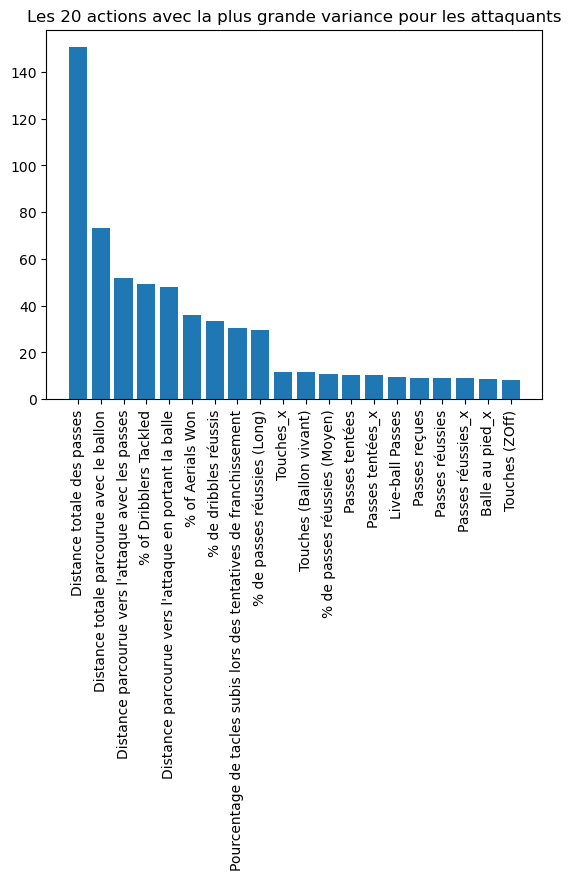

In [21]:
variances=variances.sort_values(by='Attaquant',ascending=False)
plt.bar(variances.head(20).index,variances['Attaquant'].head(20))
plt.xticks(rotation = 'vertical')
plt.title('Les 20 actions avec la plus grande variance pour les attaquants')
plt.show()

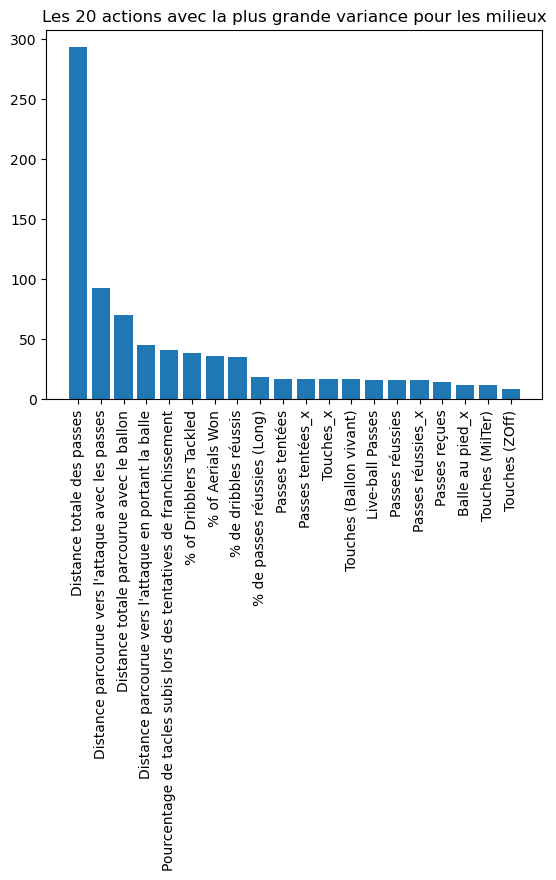

In [22]:
variances=variances.sort_values(by='Milieu',ascending=False)
plt.bar(variances.head(20).index,variances['Milieu'].head(20))
plt.xticks(rotation = 'vertical')
plt.title('Les 20 actions avec la plus grande variance pour les milieux')
plt.show()

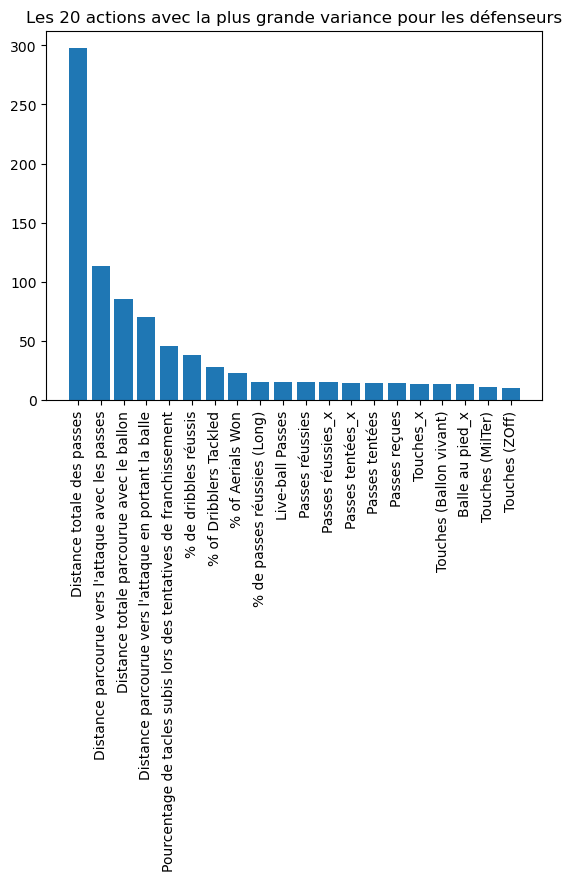

In [23]:
variances=variances.sort_values(by='Défenseur',ascending=False)
plt.bar(variances.head(20).index,variances['Défenseur'].head(20))
plt.xticks(rotation = 'vertical')
plt.title('Les 20 actions avec la plus grande variance pour les défenseurs')
plt.show()

Nous pouvons remarquer ici pour chaque poste que les 9 premières variables ont une variance plus grande que les autres, tandis que la variance des variables suivantes semblent se stabiliser. Ces variables peuvent donc être importante même si elles paraissent moins déterminantes que d'autres comme les buts ou les passes décisives. En effet même si leur décisivité lors d'un match est plus faible, le fait que leur variances soient élevées peut résulter en une forte variantion de la valeur d'un joueur. Ainsi un joueur peut voir sa valeur fortement affecté si il fait légèrement plus une action avec une forte décisivité que la moyenne ou si il fait beaucoup plus une action avec une faible décisivité que la moyenne.

### Étape 5 : Modèle

Je mets le modèle temporaire en chargeant des bases.
Comme le merge des deux bases n'est pas encore fait, je le fait là mais infine faudra le placer plus haut

In [24]:
base_work = base_work.dropna(subset=['Valeur_Millions'])
print(len(base_work['Joueur'].unique()))

476


### Etude des attaquants

L'étude se fait poste par poste, car les statistiques à prendre en compte pour mesurer la qualité d'un joueur ne sont pas les mêmes selon son poste. On peut supposer qu'un défenseur sera bon s'il est capable de bien tacler les attaquants adverses alors que cela sera de faible utilité pour un attaquant.

On commence donc par la filtrer la base pour ne conserver que les attaquants

In [25]:
base_attaquant = base_work[base_work['Position'] == 'Attaquant']

On crée ensuite une fonction qui permet de récupèrer On crée ensuite une fonction qui permet de récupèrer 

In [26]:
y = base_attaquant['pts_gagnes'].values.reshape(-1,1)

def reg_simple(x,y):
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    intercept = reg.intercept_
    slope = reg.coef_[0]
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    return intercept, slope, mse, r2

In [27]:
Var_forward = ['Buts', 'Passes décisives_x','Pénaltys marqués', 'Pénaltys tirés', 'Total des tirs ',
       'Shots on Target', 'Cartons jaunes_x', 'Cartons rouges_x', 'Touches_x',
       'Tacles_x', 'Interceptions_x', 'Balles contrées_x','Actions menant à un tir',
       'Actions menant à un but', 'Passes réussies_x', 'Passes tentées_x',
       'Passes progressives_x', 'Balle au pied_x','Possessions progressives_x', 'Dribbles tentés_x', 'Dribbles réussis_x'
       ]

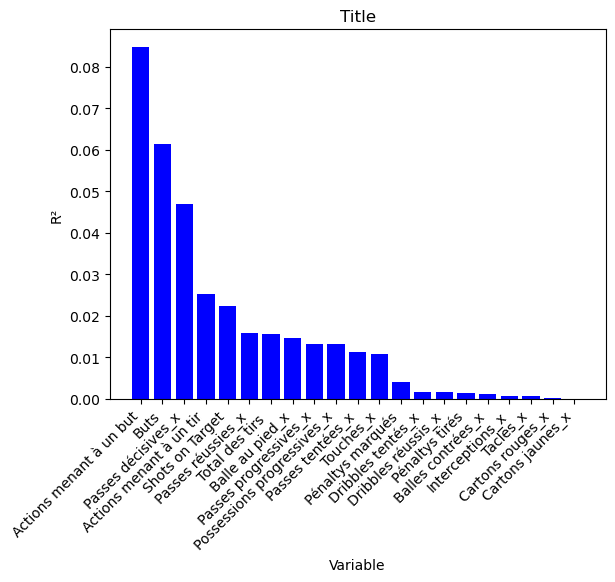

In [28]:
stat_forward = Var_forward
dict_forward = {}
for stat in stat_forward:
    x = base_attaquant[[stat]]
    result_reg = reg_simple(x,y)
    #print(result_reg)
    dict_forward[stat] = result_reg

var = dict_forward.keys()
r2list = [ele[3] for ele in dict_forward.values()]

sorted_data = sorted(zip(var, r2list), key=lambda x: x[1], reverse=True)
var_sorted, r2list_sorted = zip(*sorted_data)

plt.bar(var_sorted, r2list_sorted, color='blue')
plt.xlabel('Variable')
plt.ylabel('R²')
plt.title('Title')
plt.xticks(rotation=45, ha='right')
plt.show()

In [29]:
var_retenues = ['Buts','Passes décisives_x','Shots on Target','Total des tirs ','Passes progressives_x']
x = base_attaquant[var_retenues]
y = base_attaquant['pts_gagnes'].values.reshape(-1,1)
print(reg_simple(x,y))
intercept, coef, _ , _ = reg_simple(x,y)
list_coef = list(coef)

(array([1.16536747]), array([ 0.68630633,  0.75877836, -0.02699539, -0.0013412 ,  0.03567092]), 1.5977386096801767, 0.10360849503785341)


In [30]:
base_attaquant_saison = base_attaquant.groupby('Joueur').agg({'Buts' : 'sum',
                                    'Passes décisives_x' : 'sum', 'Shots on Target' : 'sum',
                                    'Total des tirs ' : 'sum', 'Passes progressives_x' : 'sum', 'Minutes' : 'sum', 'pts_gagnes': 'sum', 'Valeur_Millions' : 'first'}).reset_index()
print(base_attaquant_saison[['Joueur','Minutes']].sort_values(by = 'Minutes', ascending = True))

                 Joueur  Minutes
0    Abdoulaye Doucoure        1
191      Pascal Struijk        1
107          Jamal Lowe        1
125        Joel Veltman        1
132    Junior Stanislas        1
..                  ...      ...
185       Ollie Watkins     3037
50           Danny Ings     3180
30          Bukayo Saka     3181
175       Mohamed Salah     3200
91           Harry Kane     3405

[243 rows x 2 columns]


In [31]:
base_attaquant_saison['pts joueurs'] =  base_attaquant_saison[var_retenues[0]] * list_coef[0] + \
                                        base_attaquant_saison[var_retenues[1]] * list_coef[1] + \
                                        base_attaquant_saison[var_retenues[2]] * list_coef[2] + \
                                        base_attaquant_saison[var_retenues[3]] * list_coef[3] + \
                                        base_attaquant_saison[var_retenues[4]] * list_coef[4] 
base_attaquant_saison = base_attaquant_saison[base_attaquant_saison['Minutes'] >= 900]
base_attaquant_saison['pts joueur par 90'] = base_attaquant_saison['pts joueurs'] * 90  / base_attaquant_saison['Minutes']
print(base_attaquant_saison[['Joueur','pts joueur par 90']].sort_values(by = 'pts joueur par 90', ascending= False))

               Joueur  pts joueur par 90
75     Erling Haaland           1.016029
145  Leandro Trossard           0.781116
31      Callum Wilson           0.772885
175     Mohamed Salah           0.731318
91         Harry Kane           0.731160
..                ...                ...
13     Anthony Gordon           0.167730
164     Matheus Cunha           0.158268
57       Demarai Gray           0.145604
60        Diego Costa           0.056278
180       Neal Maupay           0.056031

[77 rows x 2 columns]


Définition du replacement player

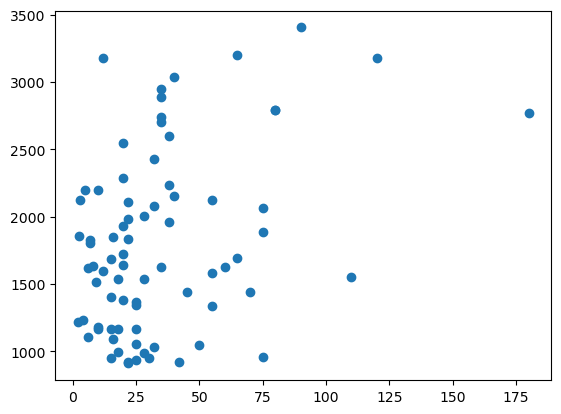

In [32]:
minutes = base_attaquant_saison['Minutes']
value = base_attaquant_saison['Valeur_Millions']

fig, ax = plt.subplots()
ax.scatter(value,minutes)
plt.show()

In [33]:
replacement_attaquant = base_attaquant_saison[(base_attaquant_saison['Valeur_Millions'] <= 10) & (base_attaquant_saison['Valeur_Millions'] >= 1)]

In [34]:
Replacement_performance = replacement_attaquant['pts joueur par 90'].mean()
print(Replacement_performance)

0.27086953975771555


In [35]:
base_attaquant_saison['PAR par 90'] = base_attaquant_saison['pts joueur par 90'] - Replacement_performance
print(base_attaquant_saison[['Joueur','PAR par 90']].sort_values(by = 'PAR par 90',ascending = False))

               Joueur  PAR par 90
75     Erling Haaland    0.745160
145  Leandro Trossard    0.510246
31      Callum Wilson    0.502015
175     Mohamed Salah    0.460448
91         Harry Kane    0.460291
..                ...         ...
13     Anthony Gordon   -0.103140
164     Matheus Cunha   -0.112601
57       Demarai Gray   -0.125265
60        Diego Costa   -0.214592
180       Neal Maupay   -0.214838

[77 rows x 2 columns]


## Les milieux de terrain

On réitère la même analyse avec les milieux de terrain mais on observe rapidement des complications

In [36]:
#On pose les nouveaux éléments
base_milieu = base_work[base_work['Position'] == 'Milieu']
y = base_milieu['pts_gagnes'].values.reshape(-1,1)
#On conserve un mélange de statistiques qui semblent pertinentes et de statitistique où on a observé une forte variance
Var_milieu = ['Buts', 'Passes décisives_x','Distance totale des passes', 'Distance totale parcourue avec le ballon', 
            "Distance parcourue vers l'attaque avec les passes",
            'Live-ball Passes','Dribbles réussis_x']



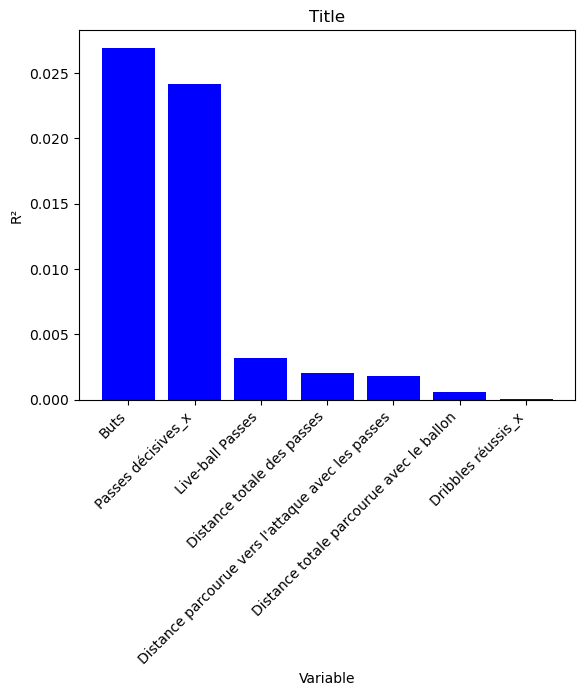

In [37]:
stat_milieu = Var_milieu
dict_milieu = {}
for stat in stat_milieu:
    x = base_milieu[[stat]]
    result_reg = reg_simple(x,y)
    #print(result_reg)
    dict_milieu[stat] = result_reg

var = dict_milieu.keys()
r2list = [ele[3] for ele in dict_milieu.values()]

sorted_data = sorted(zip(var, r2list), key=lambda x: x[1], reverse=True)
var_sorted, r2list_sorted = zip(*sorted_data)

plt.bar(var_sorted, r2list_sorted, color='blue')
plt.xlabel('Variable')
plt.ylabel('R²')
plt.title('Title')
plt.xticks(rotation=45, ha='right')
plt.show()

On observe ici des R² extrèmement faibles, beaucoup plus que chez les attaquants.
Il apparait alors conmpliqué de sélectionner des variables et continuer l'analyse pour ces joueurs-ci

On retrouve ainsi une des grandes difficultés des statistiques dans le football. Pour des joueurs au milieu de terrain dont le rôle n'est ni vraiment d'empecher l'adversaire de marquer, ni vraiment de mettre des buts, il est très difficile d'observer le performance.
Les expected goals, autre statistique devenu très populaire dans le football récemment, ne s'appliquent qu'aux attaquant également.

La transcription du modèle du Wins above replacement au football est donc ici très difficile.

## Étape 6 : Applications du modèle
### Comment aider un manager à construire son équipe

L'objectif de ce modèle simple était de créer une statistique mesurant la performance individuel d'un joueur quelque soit la qualité de l'équipe qui l'entoure. Ainsi nous obtenons le Points Above Replacement qui indique la qualité intrinsèque du joueur. 

La construction de ce modèle répondait au besoin d'une évaluation objective de la qualité d'un joueur. Une application du PAR peut se trouver dans l'aide que cela peut apporter à un manager d'équipe de football, en charge des recrutements et des transferts.

L'idée, popularisée par le manager de l'équipe de baseball d'Oakland au début des années 2000, est de chercher les joueurs qui ont objectivement une grande qualité de jeu mais dont la valeur marchande est sous-évaluée. Cette observation

Nous nous proposons de réaliser cette application sur les attaquants.

On commence par créer un graphique qui permet d'observer la relation entre la performance des joueurs, mesurée grâce à notre statistique PAR issue des données FBRef et la valeur marchande des joueurs, issue des donénes TransferMarkt

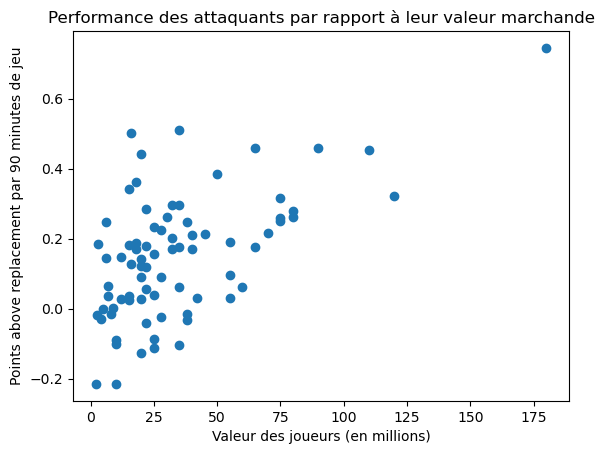

In [38]:
perf = base_attaquant_saison['PAR par 90']
value = base_attaquant_saison['Valeur_Millions']

fig, ax = plt.subplots()
ax.scatter(value,perf)
ax.set_xlabel('Valeur des joueurs (en millions)')
ax.set_ylabel('Points above replacement par 90 minutes de jeu')
ax.set_title('Performance des attaquants par rapport à leur valeur marchande')

plt.show()

On observe une bonne corrélation entre la valeur d'un joueur et sa performance mesurée grâce à la statistique PAR. Cette observation est rassurante dans un premier temps car on imagine bien que les spécialistes du football sont capables de discerner dans les grandes lignes la qualité d'un joueur et que la valeur marchande du joueur reflète en partie cette qualité. Notre statitisque PAR n'est donc pas complètement absurde.

Mais 

In [39]:
base_attaquant_saison['PAR par Millions'] = base_attaquant_saison['PAR par 90'] * 38 / base_attaquant_saison['Valeur_Millions']
print(base_attaquant_saison[['Joueur','PAR par 90','Valeur_Millions','PAR par Millions']].sort_values(by = 'PAR par Millions',ascending = False).head(10))

                Joueur  PAR par 90  Valeur_Millions  PAR par Millions
240            Willian    0.183886              3.0          2.329217
208            Rodrigo    0.247231              6.0          1.565797
31       Callum Wilson    0.502015             16.0          1.192286
34     Carlos Vinicius    0.145617              6.0          0.922242
14     Anthony Martial    0.341979             15.0          0.866348
206       Riyad Mahrez    0.442218             20.0          0.840214
137  Kelechi Iheanacho    0.363075             18.0          0.766492
145   Leandro Trossard    0.510246             35.0          0.553981
225        Solly March    0.285414             22.0          0.492989
50          Danny Ings    0.146783             12.0          0.464814
